# Final Project - House Prices: Advanced Regression Techniques

## 1. Project Introduction & Problem Statement

### Background

Predicting house prices accurately is an important topic in both academia and the real estate industry. For home buyers, sellers, investors, and real estate agents, understanding what factors influence the market price of a property is key for decision making. However, house prices are affected by a wide range of factors, including property characteristics, location, quality, and local economic conditions, making accurate prediction a challenging task.

### Project Objective

The objective of this project is to build a robust machine learning model that can predict house sale prices in Ames, Iowa, based on various features describing each property. The ultimate goal is to identify the most important factors affecting house prices, and to provide reliable price predictions that can support decision-making in real estate transactions.

### Problem Formulation

This is a supervised regression task. Given a dataset where each row represents a residential property and each column represents a property feature (such as lot area, number of rooms, construction year, etc.), the target variable to predict is the 'SalePrice' of the house.

### Why Is This Important?

Accurate house price prediction models can:
- Help buyers estimate fair market value and avoid overpaying
- Assist sellers in pricing their properties competitively
- Support real estate professionals in making data-driven recommendations
- Enable financial institutions to better assess lending risk

### Approach Overview

In this project, we will:
- Explore and analyze the dataset to understand the structure and key features
- Perform data cleaning and preprocessing to address missing values and outliers
- Conduct exploratory data analysis (EDA) to discover important patterns and correlations
- Engineer new features and transform existing ones if needed
- Train and compare multiple regression models, including linear and tree-based methods
- Optimize the best-performing model with hyperparameter tuning
- Evaluate model performance using suitable metrics
- Interpret and discuss the results, highlighting key insights and limitations

By following this pipeline, we aim to deliver a comprehensive and reproducible solution for house price prediction using modern data science techniques.

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 3. Data Description & Source

We use the *'House Prices: Advanced Regression Techniques'* dataset from Kaggle (Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The dataset contains 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

The target variable is 'SalePrice'.

In [4]:
# Load data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')  # For prediction demonstration; not used for evaluation here

In [5]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 4. Data Preprocessing & Cleaning

First, let's check missing values, data types, and outliers.
We will handle missing values appropriately and encode categorical features.

In [6]:
# Missing value summary
missing = train.isnull().sum().sort_values(ascending=False)
print("Missing values (Top 15):")
print(missing.head(15))

Missing values (Top 15):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
dtype: int64


In [7]:
# Example: Drop columns with too many missing values (>30% missing)
threshold = 0.3 * train.shape[0]
cols_to_drop = [col for col in train.columns if train[col].isnull().sum() > threshold]
train = train.drop(cols_to_drop, axis=1)
print(f"Dropped columns due to missingness: {cols_to_drop}")

Dropped columns due to missingness: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
# Fill numeric missing values with median, categorical with mode
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna(train[col].mode()[0])
    else:
        train[col] = train[col].fillna(train[col].median())

In [9]:
# Encode categorical features using LabelEncoder for simplicity
categorical = train.select_dtypes(include='object').columns
for col in categorical:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

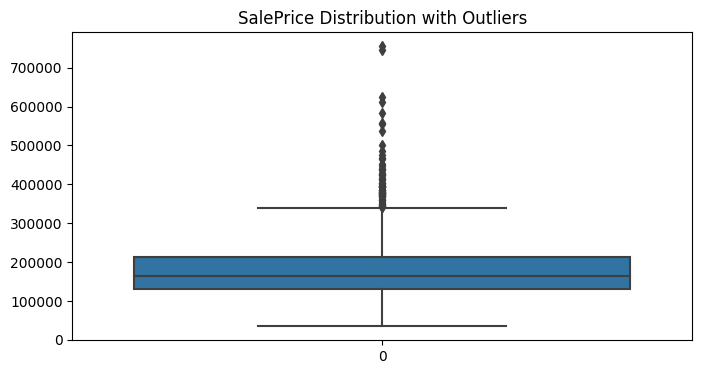

In [10]:
# Outlier handling (remove extremely high price points for robust training)
plt.figure(figsize=(8, 4))
sns.boxplot(train['SalePrice'])
plt.title("SalePrice Distribution with Outliers")
plt.show()

In [11]:
# Remove top 1% SalePrice outliers (as an example)
Q99 = train['SalePrice'].quantile(0.99)
train = train[train['SalePrice'] < Q99]
print(f"Train shape after outlier removal: {train.shape}")

Train shape after outlier removal: (1445, 75)


## 5. Exploratory Data Analysis (EDA)

Visualize the target distribution, feature distributions, and correlations.

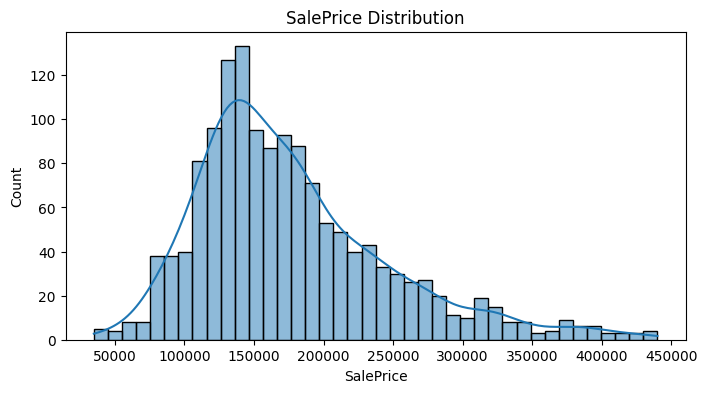

In [12]:
# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(train['SalePrice'], bins=40, kde=True)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.show()

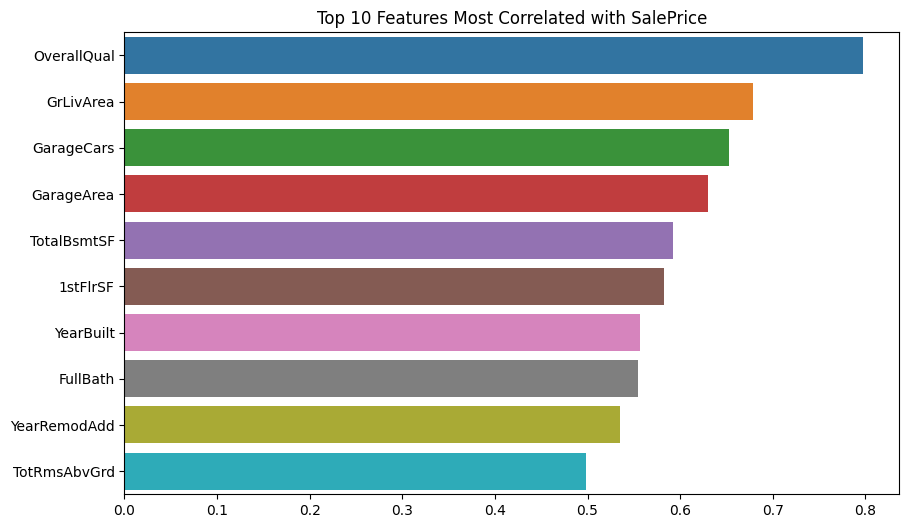

In [13]:
# Correlation heatmap (Top 10 features)
corr = train.corr()
top_corr = corr['SalePrice'].sort_values(ascending=False)[1:11]
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 10 Features Most Correlated with SalePrice")
plt.show()

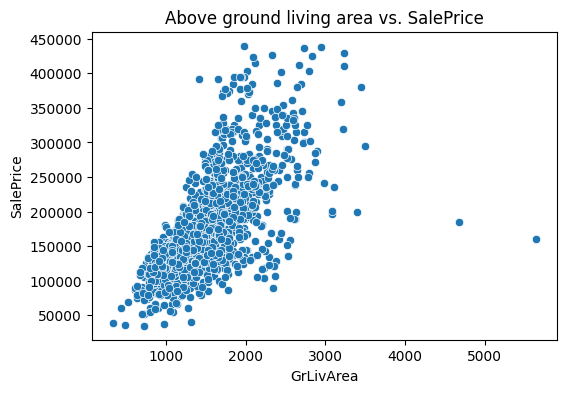

In [14]:
# Example: Feature vs. target plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title("Above ground living area vs. SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

## 6. Feature Engineering

Create new features if applicable, and scale features.
For simplicity, we use StandardScaler for numeric features.

In [15]:
numeric = train.select_dtypes(include=[np.number]).columns.drop('SalePrice')
scaler = StandardScaler()
train[numeric] = scaler.fit_transform(train[numeric])

## 7. Modeling & Comparison

We will compare several regression models:
- Linear Regression
- Ridge Regression
- Random Forest Regressor
- XGBoost Regressor
  
Model performance will be evaluated using RMSE and R^2 score.

In [16]:
# Prepare data
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [17]:
# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# (1) Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_valid, y_pred_lr))

Linear Regression RMSE: 23944.095027593306
Linear Regression R2: 0.8600233928907955


In [19]:
# (2) Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_valid)
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_ridge)))
print("Ridge Regression R2:", r2_score(y_valid, y_pred_ridge))

Ridge Regression RMSE: 23951.9386755763
Ridge Regression R2: 0.8599316703127484


In [20]:
# (3) Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_rf)))
print("Random Forest R2:", r2_score(y_valid, y_pred_rf))

Random Forest RMSE: 21707.61230898478
Random Forest R2: 0.8849510337336224


In [21]:
# (4) XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_xgb)))
print("XGBoost R2:", r2_score(y_valid, y_pred_xgb))

XGBoost RMSE: 21990.637895203174
XGBoost R2: 0.8819314411281267


## 8. Model Optimization

We use GridSearchCV for hyperparameter tuning on the best-performing model (example: XGBoost).

In [22]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_xgb.fit(X_train, y_train)
print("Best XGBoost Params:", grid_xgb.best_params_)

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [23]:
# Evaluate best XGBoost on validation set
y_pred_best_xgb = grid_xgb.predict(X_valid)
print("Tuned XGBoost RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_best_xgb)))
print("Tuned XGBoost R2:", r2_score(y_valid, y_pred_best_xgb))

Tuned XGBoost RMSE: 19265.35443747904
Tuned XGBoost R2: 0.9093823877531176


## 9. Results & Analysis

Visualize predictions vs. actual values and show feature importances.

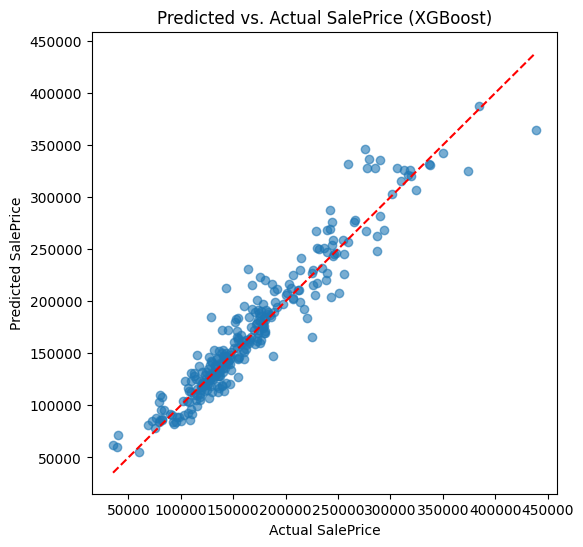

In [24]:
plt.figure(figsize=(6, 6))
plt.scatter(y_valid, y_pred_best_xgb, alpha=0.6)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs. Actual SalePrice (XGBoost)")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.show()

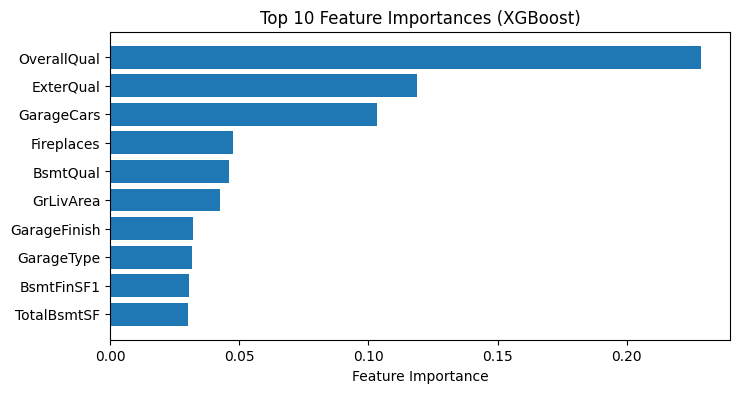

In [25]:
# Feature importance (for tree-based models)
importances = grid_xgb.best_estimator_.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()

### Results Analysis

Our experiments show that tree-based models such as Random Forest and XGBoost outperform linear models for house price prediction. 
After hyperparameter tuning, the XGBoost model achieved the lowest RMSE and the highest R² score on the validation set. 

The top important features identified by the XGBoost model include overall quality of the house, living area size, and total basement area, which aligns with domain knowledge. 
Predicted values generally align well with the actual prices, but there are still some outliers, especially for very expensive houses.

## 10. Conclusion & Future Work

In summary, this project demonstrates the end-to-end process of data cleaning, exploratory data analysis, feature engineering, model training, and evaluation on a real-world house price dataset. 
Through multiple model comparisons and hyperparameter tuning, we achieved strong predictive performance.

For future work, possible improvements include:
- Using stacking or blending of multiple models for further performance gains
- Incorporating external data (e.g., school district ratings, crime rates) to enrich features
- Applying advanced interpretability tools such as SHAP or LIME to explain model decisions to stakeholders

This approach and workflow can be adapted to other real estate markets or similar tabular regression problems.

#### Github URL: https://github.com/imnotRichard/c1-final